# Algorithms for finding structures within graphs

This code accompanies the Algorithms lecture course for computer science at Cambridge University, taught by Damon Wischik.
* [Printed lecture notes](https://www.cl.cam.ac.uk/~djw1005/redirect_algorithms.html)
* [Videos on YouTube](https://www.youtube.com/playlist?list=PLknxdt7zG11PZjBJzNDpO-whv9x3c6-1H)

#### Contents

* [Max-flow (using linear algebra)](#Max-flow-using-linear-algebra)
* [Force-weighted graph layout](#Force-weighted-graph-layout)
* [Prim's algorithm](#Prim's-algorithm)
* [Kruskal's algorithm](#Kruskal's-algorithm)
* [Topological sort](#Toposort)

In [1]:
# Make sure you have ucamcl_alg_utils.py in the current directory. It's in the
# repository with all the other notebooks. If you don't have your own copy of the
# repository, you can get the file from
# https://gitlab.developers.cam.ac.uk/djw1005/algorithms/-/blob/master/ucamcl_alg_utils.py

from ucamcl_alg_utils import DirectedGraph, UndirectedGraph, PriorityQueue, DisjointSet

# Max-flow using linear algebra

The Ford-Fulkerson algorithm, for computing a maximum flow on a network, is coursework, so you won't find it here! Instead, here is another algorithm for finding a maximum flow, based on linear algebra.

We write out the max-flow problem in linear algebra as follows. Let $E$ be the set of edges, and let $\mathbf{c}\in\mathbb{R}^E$ and $\mathbf{f}\in\mathbb{R}^E$ be the
capacities of each edge, and the flow on each edge, expressed as vectors. 

#### Flow constraints

Flow conservation says that, at every vertex $v$ except for the source and the sink,
$$
\sum_e f_e 1_{\operatorname{end}(e)=v} = \sum_e f_e 1_{\operatorname{start}(e)=v}
$$
In words, the sum of flows on all edges wthat end at $v$ is equal to the sum of flows on all edges that start at $v$. The notation $1_X$ is called the *indicator function*, also known as *one-hot coding*; it is equal to $1$ when the condition $X$ is true, and $0$ when $X$ is false. We can rewrite this in matrix notation as
$$
\sum_e A_{v e} f_e=0 \qquad \text{where} \qquad A_{v e}=1_{\operatorname{start}(e)=v} - 1_{\operatorname{end}(e)=v}
$$
or, even more succinctly,
$$
A \mathbf{f} = 0
$$
where $A$ is a matrix with $V-2$ columns and $E$ rows.

There is another constraint on $\mathbf{f}$. For it to be a valid flow, it also has to satisfy the capacity constraints: it can't be negative, and it has to fit within capacity. In vector notation, $\mathbf{f}\geq\mathbf{0}$ and $\mathbf{f}\leq\mathbf{c}$.

#### Flow value

The value of $\mathbf{f}$ is the net flow out of the source, in other words
$$
\operatorname{value}(\mathbf{f}) = \sum_e f_e b_e
\qquad\text{where}\qquad
b_e=1_{\operatorname{start}(e)=s} - 1_{\operatorname{end}(e)=s}
$$
Or, in vector notation,
$$
\operatorname{value}(\mathbf{f}) = \mathbf{b}^\mathsf{T} \mathbf{f}
$$


#### Max flow

In summary, the max-flow problem can be written as
$$
\begin{align}
&\text{maximize} && \mathbf{b}^\mathsf{T}\mathbf{f}\\
&\text{over} && \mathbf{f}\in\mathbb{R}^E,\; \mathbf{f}\geq \mathbf{0},\; \mathbf{f}\leq \mathbf{c}\\
&\text{such that} && A\mathbf{f} = \mathbf{0}.
\end{align}
$$
This is an example of a _linear programming problem_, for which there are standard library solvers. All we need to do is
set up the vectors and matrices, then call the library routine. The standard solvers do not respect the Integrality Lemma, i.e. there is no guarantee that we'll end up with an integer flow, even if all capacities are integer.

In [2]:
import pandas
import numpy as np

df = pandas.read_csv('https://www.cl.cam.ac.uk/teaching/2021/Algorithms/ticks/res/flownetwork_02.csv')
df

u  v  capacity
0  0  1     10000
1  1  2     10000
2  2  5     10000
3  0  3      8000
4  3  2      8000
5  1  4      6000
6  4  5      6000

In [3]:
s,t = 0,5
V = set(df.u) | set(df.v)
b = np.where(df.u==s,1,0) - np.where(df.v==s,1,0)
A = np.row_stack([np.where(df.u==v,1,0) - np.where(df.v==v,1,0) for v in V if v not in {s,t}])

import scipy.optimize
res = scipy.optimize.linprog(c=-b,   # minimize c.x
                             # over x such that bounds[0] <= x <= bounds[1]
                             bounds=np.column_stack([np.zeros(len(df)), df.capacity]), 
                             # such that A_eq @ x = b_eq
                             A_eq=A, b_eq=np.zeros(len(A)) 
                             )
df['flow'] = res.x
print(f"flow value {b @ res.x}")
df

flow value 15999.99997857086


u  v  capacity         flow
0  0  1     10000  9845.032412
1  1  2     10000  3845.032425
2  2  5     10000  9999.999992
3  0  3      8000  6154.967567
4  3  2      8000  6154.967567
5  1  4      6000  5999.999986
6  4  5      6000  5999.999986

# Force-weighted graph layout

This graph is from [Algorithms section 4.3](https://algs4.cs.princeton.edu/43mst/) by Sedgewick and Wayne. They plot the graph and show a minimum spanning tree.

In [4]:
g = UndirectedGraph([('0','2',26), ('0','4',38), ('0','6',58), ('0','7',16),
                     ('1','2',36), ('1','3',29), ('1','5',32), ('1','7',19),
                     ('2','3',17), ('2','6',40), ('2','7',34),
                     ('3','6',52),
                     ('4','5',35), ('4','6',93), ('4','7',37),
                     ('5','7',28)])

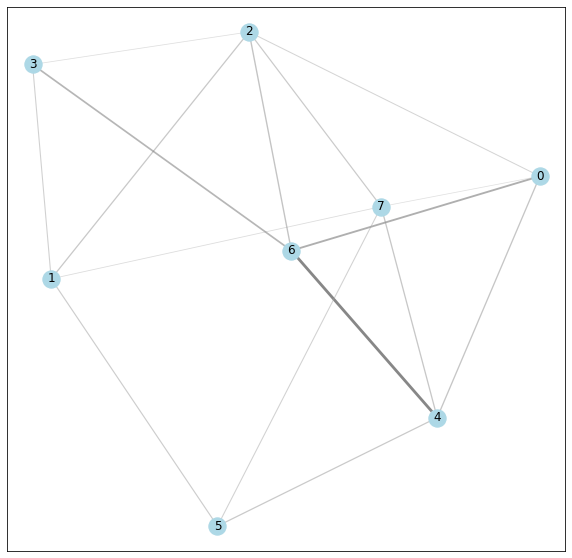

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
G.add_edges_from([(v1.id, v2.id, {'weight':w}) for v1,v2,w in g.edges])

fig,ax = plt.subplots(figsize=(10,10))
pos = nx.spring_layout(G)
for v1,v2,w in g.edges:
    _w = w / 100
    nx.draw_networkx_edges(G, pos, edgelist=[(v1.id,v2.id)], width=(0.1+0.9*_w)*3, alpha=.5, edge_color=str(1-(0.1+0.9*_w)))

nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue')
nx.draw_networkx_labels(G, pos)

plt.show()

# Prim's algorithm

In [6]:
def prim(g, s):
    for v in g.vertices:
        v.distance = float('inf')
        v.in_tree = False
    s.come_from = None
    s.distance = 0
    toexplore = PriorityQueue([s], sortkey=lambda v: v.distance)

    while not toexplore.is_empty():
        v = toexplore.popmin()
        v.in_tree = True
        for (w, edgeweight) in v.neighbours:
            if (not w.in_tree) and edgeweight < w.distance:
                w.distance = edgeweight
                w.come_from = v
                if w in toexplore:
                    toexplore.decreasekey(w)
                else:
                    toexplore.push(w)

In [7]:
prim(g, g.vertex['2'])

tree_edges = [(v.come_from, v) for v in g.vertices if v.come_from is not None]
', '.join(f'{u}-{v}' for u,v in tree_edges)

'7-5, 2-3, 0-7, 7-1, 5-4, 2-0, 2-6'

# Kruskal's algorithm

In [8]:
def kruskal(g):
    tree_edges = []
    partition = DisjointSet()
    for v in g.vertices:
        partition.add_singleton(v)
    edges = sorted(g.edges, key = lambda e: e[2])

    for (u,v,edgeweight) in edges:
        p = partition.get_set_with(u)
        q = partition.get_set_with(v)
        if p != q:
            tree_edges.append((u,v))
            partition.merge(p, q)
    return tree_edges

In [9]:
# The graph is defined above, under Prim's algorithm

tree_edges = kruskal(g)
', '.join(f'{u}-{v}' for u,v in tree_edges)

'0-7, 2-3, 1-7, 0-2, 5-7, 4-5, 2-6'

# Toposort

In [10]:
def toposort(g):
    for v in g.vertices:
        v.visited = False
        # v.colour = white
    totalorder = []
    for v in g.vertices:
        if not v.visited:
            visit(v, totalorder, prefix='')
    return totalorder

# The prefix argument isn't necessary for the algorithm,
# but it helps print out a nice (rotated) flame chart.

def visit(v, totalorder, prefix):
    print(f"{prefix}{v}-start")
    v.visited = True
    # v.colour = grey
    for w in v.neighbours:
        if not w.visited:
            visit(w, totalorder, prefix+'| ')
    print(f"{prefix}{v}-end")
    totalorder.insert(0, v)
    # v.colour = black

In [11]:
g = DirectedGraph([('a','b'), ('a','c'),
                   ('c','d'), ('c','f'),
                   ('d','b'), ('d','e'), ('d','g'),
                   ('h','f'), ('h','i'),
                   ('i','g')])
totalorder = toposort(g)
print("\nOrder:", ','.join(str(s) for s in totalorder))

c-start
| d-start
| | b-start
| | b-end
| | e-start
| | e-end
| | g-start
| | g-end
| d-end
| f-start
| f-end
c-end
h-start
| i-start
| i-end
h-end
a-start
a-end

Order: a,h,i,c,f,d,g,e,b
